In [84]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import math
from sklearn.svm import SVR, LinearSVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

In [3]:
sys.path.insert(0, r'../src')
from function_cache import *

In [4]:
T_contracts_sequence = pd.read_csv('../data/processed/roll_period/T_contracts_sequence.csv', index_col=0)

In [6]:
# start and end date of roll period
T_roll_period = pd.read_csv(
    "../data/processed/roll_period/T_roll_period.csv", index_col="contract"
).astype("datetime64[ns]")

In [7]:
T_0min = pd.read_csv('../data/processed/price_before_close/T_0min.csv', index_col='Trading_Day', parse_dates=True)
T_5min = pd.read_csv('../data/processed/price_before_close/T_5min.csv', index_col='Trading_Day', parse_dates=True)
T_10min = pd.read_csv('../data/processed/price_before_close/T_10min.csv', index_col='Trading_Day', parse_dates=True)
T_15min = pd.read_csv('../data/processed/price_before_close/T_15min.csv', index_col='Trading_Day', parse_dates=True)

In [8]:
T_features = pd.read_csv('../data/processed/candidate_features/T_features.csv', index_col=0)
T_spread_change = pd.read_csv('../data/processed/different_ys/T_spread_change.csv', index_col=0)

In [15]:
T_spread_change.head()

,0min_0min,0min_5min,0min_10min,0min_15min,5min_0min,5min_5min,5min_10min,5min_15min,10min_0min,10min_5min,10min_10min,10min_15min,15min_0min,15min_5min,15min_10min,15min_15min,contract_code
contract,,,,,,,,,,,,,,,,,
T1509,0.555,0.550,0.575,0.565,0.620,0.615,0.640,0.630,0.580,0.575,0.600,0.590,0.575,0.570,0.595,0.585,0
T1512,0.500,0.500,0.535,0.540,0.455,0.455,0.490,0.495,0.380,0.380,0.415,0.420,0.455,0.455,0.490,0.495,1
T1603,0.300,0.295,0.255,0.260,0.290,0.285,0.245,0.250,0.300,0.295,0.255,0.260,0.265,0.260,0.220,0.225,2
T1606,0.085,0.100,0.070,0.075,0.085,0.100,0.070,0.075,0.095,0.110,0.080,0.085,0.090,0.105,0.075,0.080,3
T1609,0.010,0.010,0.010,0.005,0.020,0.020,0.020,0.015,0.040,0.040,0.040,0.035,0.040,0.040,0.040,0.035,4


In [23]:
X = T_features.values
y = T_spread_change['0min_0min'].values

In [50]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [111]:
svr = SVR(kernel='linear', C=0.005)
svr.fit(X, y)
svr.score(X, y)

0.34033458764853397

In [53]:
def f_importances(coef, names):
    imp = coef
    imp, names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

In [112]:
coef_sr = pd.Series(svr.coef_[0], index=T_features.columns)
coef_sr

5d_spread_change                  0.001733
10d_spread_change                -0.001440
15d_spread_change                 0.007327
20d_spread_change                 0.007786
10d_act_price_exp_mva             0.017232
-1d_corr_act_price_def_OI        -0.002341
-1d_corr_def_price_def_OI        -0.002004
10d_spread_std_divided_by_std    -0.004777
10d_current_price                -0.000874
1d_z_diff_act_price_def_price    -0.017510
-1d_corr_act_price_def_volume    -0.000786
-1d_corr_def_price_def_volume    -0.000277
10d_current_spread               -0.002152
-1d_std                           0.015167
-1d_corr_act_price_def_price      0.008964
-1d_corr_act_OI_def_volume        0.001921
-1d_corr_act_OI_def_OI           -0.003733
-1d_corr_def_volume_def_OI       -0.008873
-1d_corr_def_OI_spread            0.013849
-1d_corr_def_volume_spread        0.008614
1d_z_diff_act_price_def_OI        0.018122
-1d_corr_act_volume_def_volume   -0.001881
-1d_corr_act_volume_def_OI        0.004137
-1d_corr_ac

In [113]:
plt.rcParams['figure.figsize'] = [25, 15]

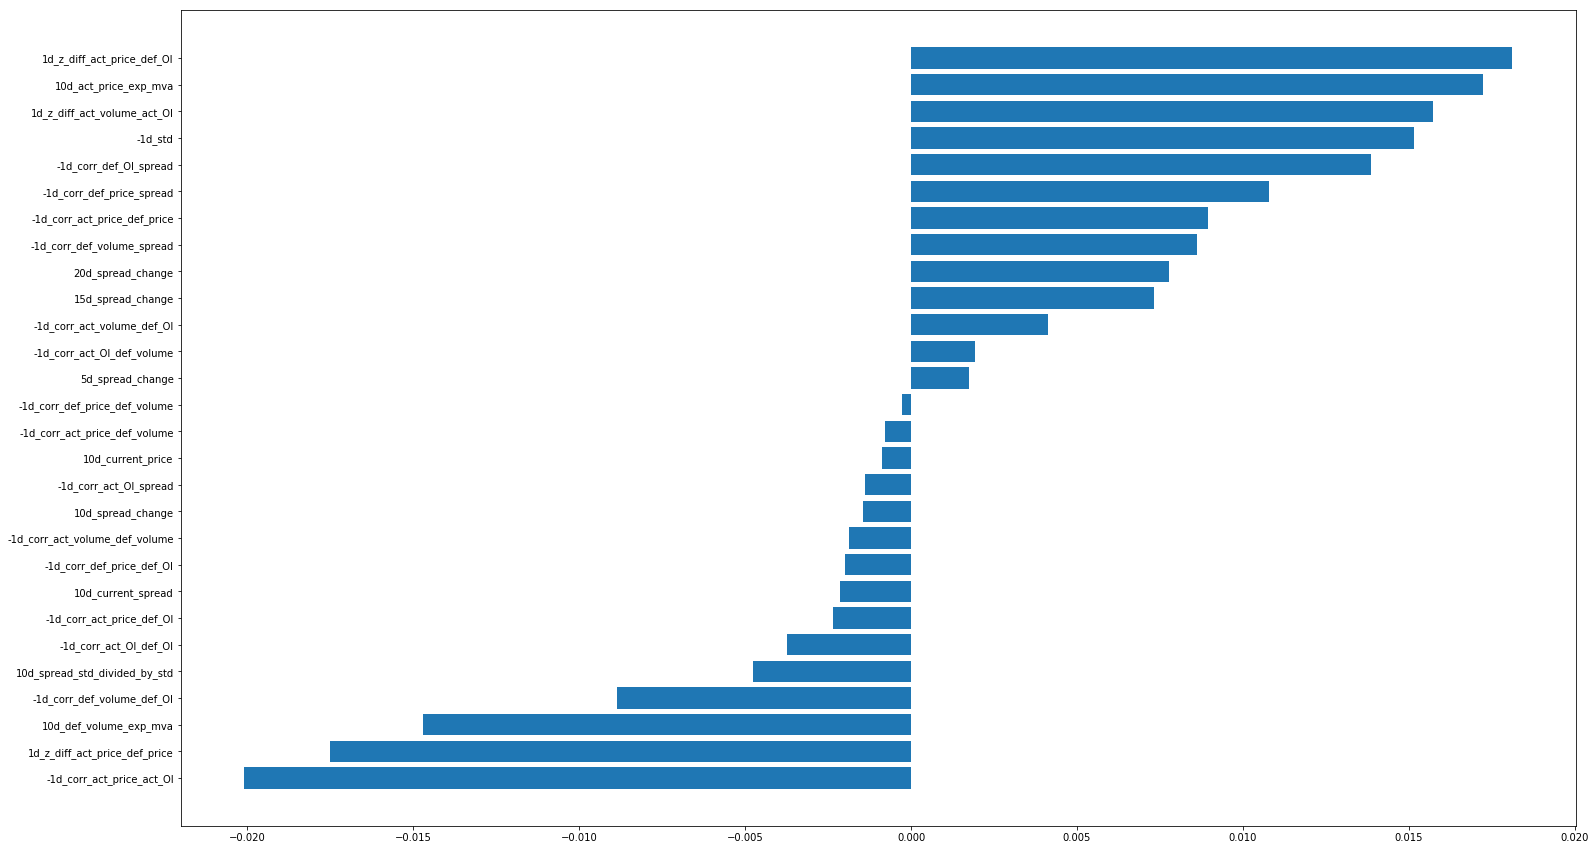

In [114]:
f_importances(svr.coef_[0], T_features.columns)

In [115]:
y_pred = svr.predict(X)

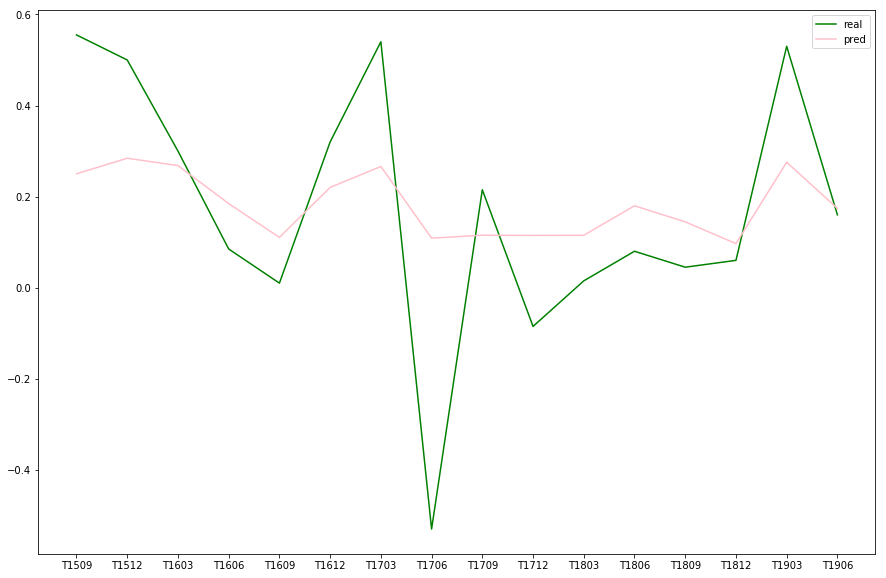

In [116]:
plt.rcParams['figure.figsize'] = [15, 10]
plt.plot(T_spread_change['0min_0min'].index, T_spread_change['0min_0min'].values, c='g', label='real')
plt.plot(T_spread_change['0min_0min'].index, y_pred, c='pink', label='pred')
plt.legend(loc='upper right')

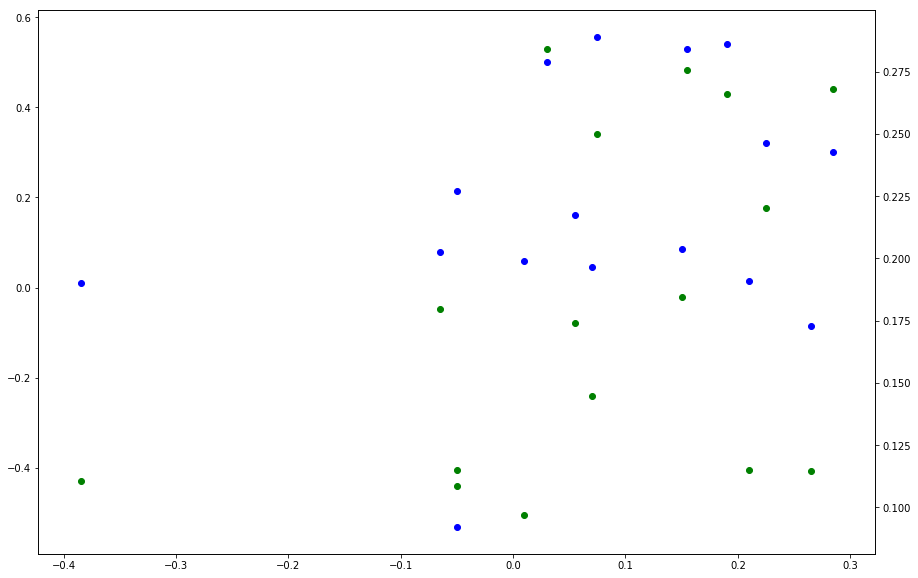

In [117]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(T_features.iloc[:, 2].values, y, c='b')
ax2 = plt.twinx(ax)
ax2.scatter(T_features.iloc[:, 2].values, y_pred, c='g')
plt.show()

## Tuning C

In [80]:
C_list = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05,  0.1, 1, 10]

In [83]:
for C in C_list:
    svr = LinearSVR(C=C)
    svr.fit(X, y)
    print(svr.score(X, y))

-0.39335873572363633
-0.3511975628802775
-0.29803643110368405
0.048809651710604474
0.3565569887722857
0.9473412995729514
0.9769438150610423
0.9999999815922815
0.9999999916445876


In [107]:
n = 4
kf = KFold(n_splits=n, shuffle=True)
score = pd.DataFrame(index=range(n), columns=C_list)
i = 0

for train_index, test_index in kf.split(X):
    print(test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    for C in C_list:
        svr = LinearSVR(C=C)
        svr.fit(X_train, y_train)
        score.loc[i, C] = svr.score(X_test, y_test)
    i = i + 1

[ 0  2 10 14]
[ 1  3  4 13]
[ 5  9 11 12]
[ 6  7  8 15]


In [110]:
score.mean()

0.0001    -0.935525
0.0005    -0.940651
0.0010    -0.928060
0.0050    -0.850681
0.0100    -0.956099
0.0500    -1.797355
0.1000    -1.852947
1.0000    -1.998297
10.0000   -1.998324
dtype: float64